In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import time
import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm
from module.lino_module.model import TransformerModel, WithAuxiliary, LossWithAuxiliary
from module.lino_module.training import training_with_auxiliary
from module.lino_module.ploter import confirmation,  confirmation_plot, val_time_series

In [2]:
saving = True

parent_path = '../'
data = pd.read_csv(parent_path + '/data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 10
d_model = 16
dilation = 3
src_tgt_seq = (9, 9)
step_num = 5
scaler = StandardScaler

dataset_kw = {'data': data,
              'seq': seq,
              'd_model': d_model,
              'dilation': dilation,
              'src_tgt_seq': src_tgt_seq,
              'step_num': step_num,
              'daily': True,
              'weekday': True,
              'weekly': False,
              'monthly': True,
              'scaler': scaler,
              'batch_size': 64,
              'train_rate': 0.9}

train, test = tde_dataset_wm(**dataset_kw)

In [3]:
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')

cat_dim = dataset_kw['daily'] + dataset_kw['weekday'] + dataset_kw['weekly'] + dataset_kw['monthly']
dim = d_model * (cat_dim + 1)

base_model_kw = {'d_model': dim,
                 'nhead': 8,
                 'device': device}

auxiliary_model_kw = {'d_model': dim,
                      'nhead': 8,
                      'device': device}

# モデルと損失関数
base_model = TransformerModel(**base_model_kw)
auxiliary_model = TransformerModel(**auxiliary_model_kw)
model = WithAuxiliary(base_model, auxiliary_model).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
base_func, auxiliary_func = nn.MSELoss(), nn.MSELoss()
criterion = LossWithAuxiliary(base_func, auxiliary_func).to(device)

# 学習率の設定
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
auxiliary_lr = lr * 1e-1
optimizer = Adam([
                  {'params': model.base.parameters()},
                  {'params': model.auxiliary.parameters(), 'lr': auxiliary_lr}],
                  lr=lr, betas=(0.95, 0.98), eps=10e-9)

In [4]:
epochs = 100
training_kwrgs = {'model': model,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 80}
loss_pack = training_with_auxiliary(**training_kwrgs)

------------------------------------ start -------------------------------------
                                    epoch_0                                     
train_loss:  1.3148 | validation_loss:  1.2347 | test_loss:  0.2981 | auxiliary_rate:  0.6379
                                    epoch_10                                    
train_loss:  0.5127 | validation_loss:  0.4989 | test_loss:  0.3008 | auxiliary_rate:  0.4628
                                    epoch_20                                    
train_loss:  0.388 | validation_loss:  0.3789 | test_loss:  0.3632 | auxiliary_rate:  0.4915
                                    epoch_30                                    
train_loss:  0.349 | validation_loss:  0.3313 | test_loss:  0.2879 | auxiliary_rate:  0.3862
                                    epoch_40                                    
train_loss:  0.3166 | validation_loss:  0.3092 | test_loss:  0.2817 | auxiliary_rate:  0.4575
                                    epoch_50  

In [5]:
# ファイル名の作成
name = ''
del dataset_kw['batch_size'], dataset_kw['train_rate']
for key, value in dataset_kw.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})'
    else:
        name += f'{key}({value})'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


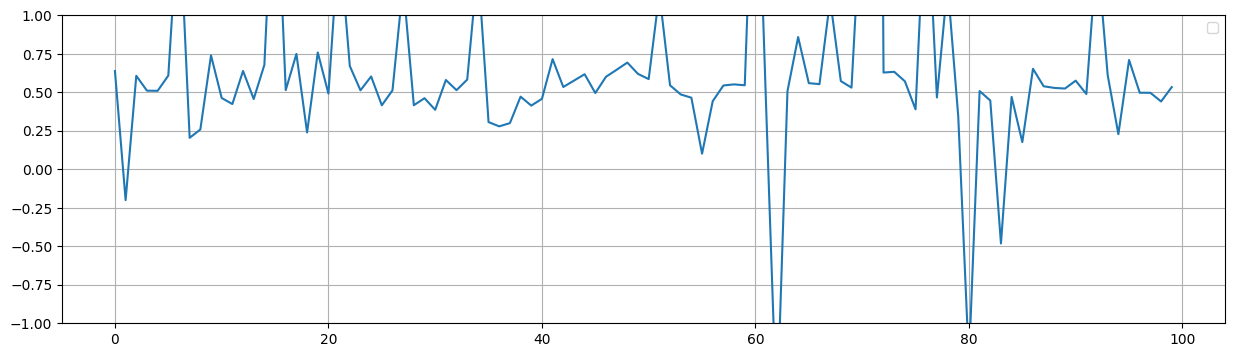

In [6]:
auxiliary_rate = [np.array(loss).mean() for loss in loss_pack['train']['auxiliary_rate']]
plt.figure(figsize=(15,4))
plt.plot(auxiliary_rate)
plt.ylim(-1, 1)
plt.grid(axis='x')
plt.grid(axis='y')
plt.legend()
plt.show()

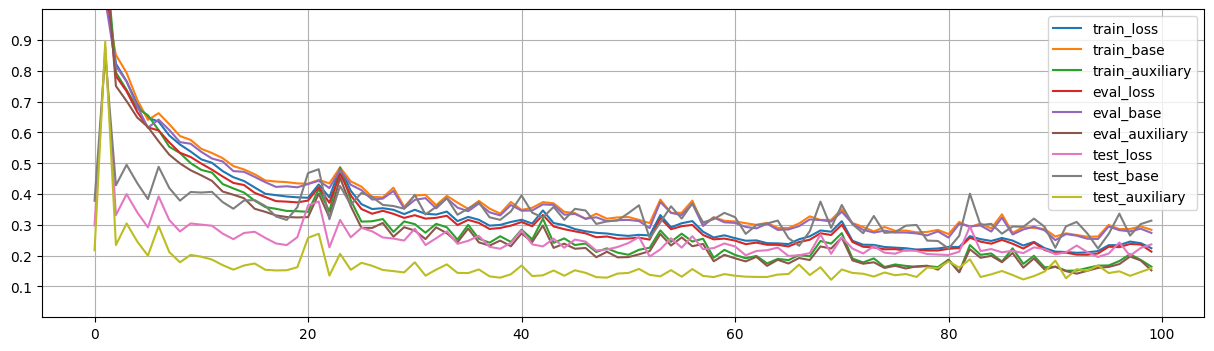

In [7]:
plt.figure(figsize=(15,4))


for mode, values in loss_pack.items():
    for key, value in values.items():
        if key == 'auxiliary_rate':
            pass
        else:
            plt.plot([np.array(loss).mean() for loss in value], label=f'{mode}_{key}')

plt.yticks([round(i*1e-1, 2) for i in range(1, 10)])
plt.ylim(0, 2)
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
plt.legend()
plt.show()

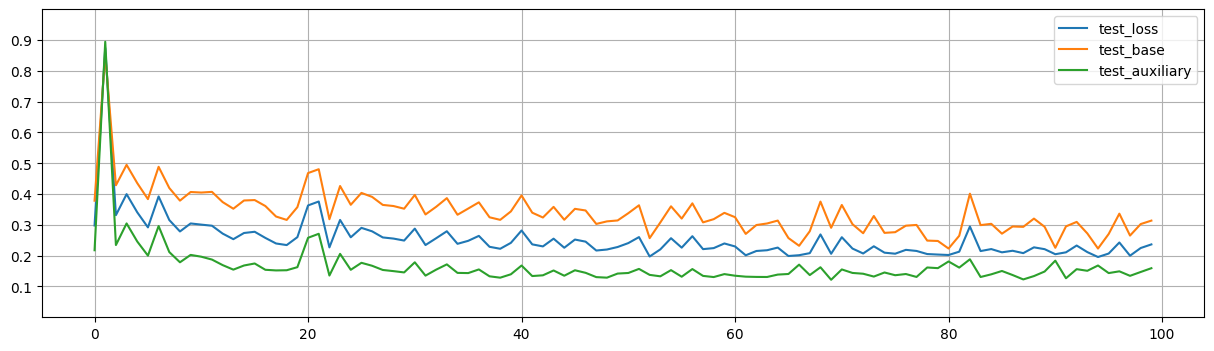

In [8]:
mode = 'test'

plt.figure(figsize=(15,4))
for key, value in loss_pack[mode].items():
    if key == 'auxiliary_rate':
        pass
    else:
        plt.plot([np.array(loss).mean() for loss in value], label= f'{mode}_{key}')

plt.yticks([round(i*1e-1, 2) for i in range(1, 10)])
plt.ylim(0, 2)
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
plt.legend()
plt.show()

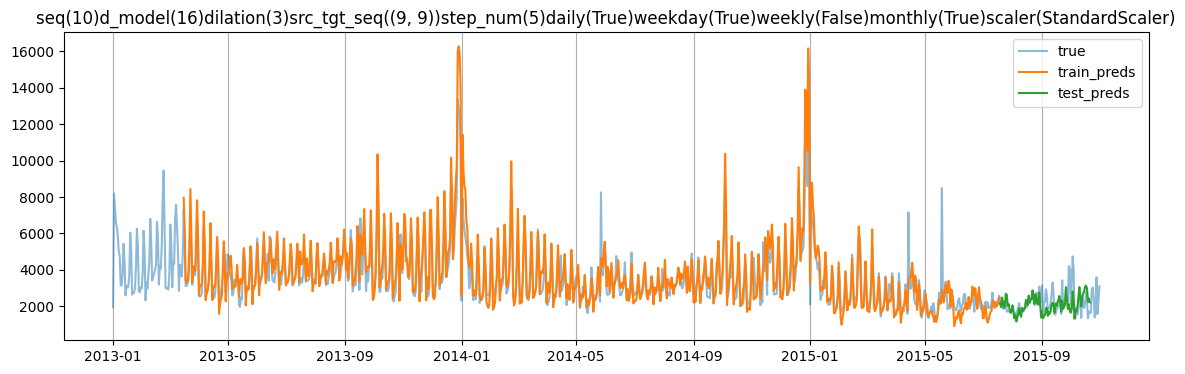

In [9]:
img_path = './imgs/img_ax/'
figsize = (14, 4)
saving = True
train_preds, test_preds = confirmation(model, train, test, device)
train_time_series, test_time_series, original = val_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

## モデルの保存

In [17]:
if saving:
    # 訓練済みモデルパラメータの保存
    model_dir = './models_ax/'
    torch.save(model.state_dict(), model_dir + name + '.pht')

    # 訓練時引数の保存
    inf_dir = model_dir + 'kw_inf/'
    kw_obj = {'dataset': dataset_kw,
              'base_model': base_model_kw,
              'auxiliary_model': auxiliary_model_kw}
    with open(inf_dir + name + '.pkl', 'wb') as f:
        pickle.dump(kw_obj, f)
    print('model is saved')
else:
    print('Not saved')

model is saved


In [ ]:
params = 0
for p in auxiliary_model.parameters():
    if p.requires_grad:
        params += p.numel()
        
print(params)